# 基于CNN的图像分类算法

In [14]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
from ultralytics import YOLO
import cv2
from PIL import Image
import os
import json
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 基础知识

### ImageFolder函数

torchvision.datasets.ImageFolder 是 PyTorch 中一个用于加载图像数据的类，适用于结构化文件夹格式的数据集。

参数名	|类型	|默认值	|说明	|示例
---|---|---|---|---|
root	|str	|必需	|数据集根目录，按类别组织的子文件夹路径	|root="path/to/dataset"
transform	|callable	|None	|图像级变换函数，常用 transforms.Compose	|transform=transforms.ToTensor()
target_transform	|callable	|None	|标签级变换函数	|target_transform=lambda x: x*2
loader	callable	|PIL.Image.open	|自定义图像加载函数	|loader=custom_loader_function
is_valid_file	|callable	|None	|自定义文件过滤函数，返回布尔值	|is_valid_file=lambda x: x.endswith('.jpg')

ImageFolder 要求数据集目录结构如下：

每个子文件夹名被视为一个类别标签。

ImageFolder 属性一览表  

属性名	|类型	|说明
---|---|---|
classes	|list[str]	|类别名称列表，按字母顺序排列。
class_to_idx	|dict[str, int]	|类别到索引的映射字典。
samples	|list[tuple]	|包含 (文件路径, 类别索引) 的元组列表。
imgs (已废弃)	|list[tuple]	|与 samples 相同，已被废弃但仍兼容。
targets	|list[int]	|图像标签的索引列表。
root	|str	|数据集的根目录路径。
transform	|callable	|应用于图像的变换操作。
target_transform	|callable	|应用于标签的变换操作。

In [2]:
# 加载数据集
root_dir = "../data/cats_and_dogs_small/validation/"

# 定义图像变换
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 可选：调整图像大小
    transforms.ToTensor()           # 转换为张量
])

dataset = datasets.ImageFolder(root=root_dir, transform=transform)

In [3]:
# 查看类别标签
print("类别标签:", dataset.classes)
print("类别到索引映射:", dataset.class_to_idx)

类别标签: ['cats', 'dogs']
类别到索引映射: {'cats': 0, 'dogs': 1}


### Compose函数

transforms.Compose 是 PyTorch 中 torchvision.transforms 模块提供的一个函数，用于将多个图像变换操作组合成一个序列，方便应用到数据集中的图像。

变换操作	|说明
---|---
transforms.Resize(size)	|调整图像大小到给定尺寸（支持整数和元组格式）。
transforms.CenterCrop(size)	|中心裁剪指定大小的图像。
transforms.RandomCrop(size)	|随机裁剪指定大小的图像。
transforms.RandomHorizontalFlip(p)	|以概率 p 水平翻转图像。
transforms.RandomRotation(degrees)	|随机旋转图像。
transforms.ColorJitter()	|调整亮度、对比度、饱和度等。
transforms.ToTensor()	|将图像转换为张量，且像素值归一化到 [0,1]。
transforms.Normalize(mean, std)	|使用均值和标准差对图像标准化。
transforms.Grayscale()	|转换为灰度图像。

In [30]:
from torchvision import transforms

# 定义图像变换操作
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # 调整图像大小
    transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 颜色抖动
    transforms.ToTensor(),                  # 转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化
])

# 示例应用
from PIL import Image

# 加载图像
img = Image.open("../data/cats_and_dogs_small/train/cats/cat.2.jpg")

# 应用变换
transformed_img = transform(img)

### 输入批次大小

图像批次大小解释: 假设数据为：torch.Size([32, 3, 224, 224])  
该张量的形状通常用于 PyTorch 中的图像批次输入，遵循 NCHW 格式：

- N (批量大小): 32
- C (通道数): 3 (RGB 图像)
- H (图像高度): 224 像素
- W (图像宽度): 224 像素

## 查看图像

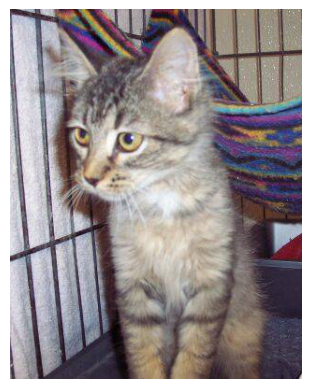

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 加载图像 (本地路径)
image = Image.open("../data/cats_and_dogs_small/train/cats/cat.2.jpg")

# 显示图像
plt.imshow(image)
plt.axis("off")  # 隐藏坐标轴
plt.show()

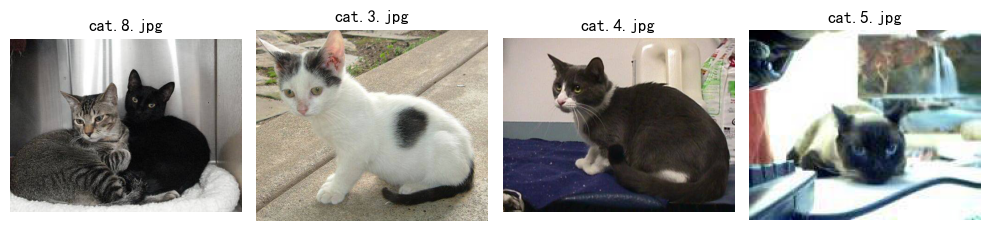

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 加载多张图像
path = "../data/cats_and_dogs_small/train/cats/"
image_paths = [path + i for i in ["cat.8.jpg", "cat.3.jpg", "cat.4.jpg", "cat.5.jpg"]]

# 创建子图布局 (1行4列)
fig, axes = plt.subplots(1, 4, figsize=(10, 8))

# 遍历每个子图
for ax, img_path in zip(axes.ravel(), image_paths):
    image = Image.open(img_path)
    ax.imshow(image)
    ax.set_title(img_path.split('/')[-1])  # 显示文件名
    ax.axis("off")  # 隐藏坐标轴

plt.tight_layout()
plt.show()

## 数据准备

In [59]:
# 加载图像并生成批次数据
def generator(data_path, label_path, batch_size):
    """
    读取图像，并生成批次数据

    参数说明
    ----------
    data_path : {str}
        图像文件夹地址
    batch_size : {int} 
        输入数据的批次大小，正整数
    label_path : {str} 
        标签字典保存地址

    返回值
    -------
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[批次，目标，特征时间编码，目标时间编码]
    """
    # 定义图像变换操作
    transform = transforms.Compose([
        transforms.Resize((224, 224)),         # 调整图像大小
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 颜色抖动
        transforms.ToTensor(),                  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])
    
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    print(f"图像个数：{len(dataset)}, 尺寸：{dataset[0][0].shape}")

    # 获取类别名称和索引
    class_to_idx = dataset.class_to_idx  # 字典形式：类别名称 -> 索引
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # 反向字典：索引 -> 类别名称
    with open(os.path.join(label_path + '/idx_to_class.json'), 'w') as f:
        json.dump(idx_to_class, f)
    
    # 数据加载器
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 查看一个批次数据
    images, labels = next(iter(dataloader))
    print(f"图像批次大小: {images.shape}")
    print(f"标签批次大小: {labels.shape}")
    print(f"图像批次个数: {len(dataloader)}")

    return dataloader

In [60]:
# 训练集
params1 = {
    "data_path": "../data/cats_and_dogs_small/train",
    "label_path": "../outputs/labels",
    "batch_size": 32,
}
print("训练集：")
train_loader = generator(**params1)

# 验证集
params2 = {
    "data_path": "../data/cats_and_dogs_small/validation",
    "label_path": "../outputs/labels",
    "batch_size": 32,
}
print("验证集：")
valid_loader = generator(**params2)

# 测试集
params3 = {
    "data_path": "../data/cats_and_dogs_small/test",
    "label_path": "../outputs/labels",
    "batch_size": 32,
}
print("测试集：")
test_loader = generator(**params3)

训练集：
图像个数：2000, 尺寸：torch.Size([3, 224, 224])
图像批次大小: torch.Size([32, 3, 224, 224])
标签批次大小: torch.Size([32])
图像批次个数: 63
验证集：
图像个数：1000, 尺寸：torch.Size([3, 224, 224])
图像批次大小: torch.Size([32, 3, 224, 224])
标签批次大小: torch.Size([32])
图像批次个数: 32
测试集：
图像个数：1000, 尺寸：torch.Size([3, 224, 224])
图像批次大小: torch.Size([32, 3, 224, 224])
标签批次大小: torch.Size([32])
图像批次个数: 32


## 模型定义

In [27]:
class CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=10, input_size=32, conv_layers=None, fc_layers=None):
        super(CNN, self).__init__()

        # 默认卷积层配置
        if conv_layers is None:
            conv_layers = [
                (input_channels, 32, 3),  # (输入通道, 输出通道, 卷积核大小)
                (32, 64, 3),
                (64, 128, 3),
                (128, 256, 3),
            ]

        # 动态构建卷积层，添加池化层
        self.conv_layers = nn.ModuleList()
        feature_map_size = input_size  # 初始化特征图尺寸
        for in_channels, out_channels, kernel_size in conv_layers:
            padding = (kernel_size - 1) // 2  # 计算填充
            self.conv_layers.append(nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding))
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.MaxPool2d(
                kernel_size=2, stride=2))  # 池化操作
            feature_map_size = feature_map_size // 2  # 每次池化后尺寸减半

        # 计算经过所有卷积层后特征图的总维度
        self.conv_output_features = feature_map_size * \
            feature_map_size * conv_layers[-1][1]

        # 默认全连接层配置
        if fc_layers is None:
            fc_layers = [512]

        # 构建全连接层
        self.fc_layers = nn.ModuleList()
        in_features = self.conv_output_features
        for out_features in fc_layers:
            self.fc_layers.append(nn.Linear(in_features, out_features))
            self.fc_layers.append(nn.ReLU())
            in_features = out_features

        # 最终分类层
        self.fc_layers.append(nn.Linear(in_features, num_classes))

    def forward(self, x):
        # 通过卷积层
        for layer in self.conv_layers:
            x = layer(x)

        # 展平特征图
        x = x.view(x.size(0), -1)

        # 通过全连接层
        for layer in self.fc_layers:
            x = layer(x)

        return x

## 模型训练

In [28]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        train_correct_predictions = 0
        for batch_x, batch_y in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) 
            batch_y = batch_y.to(device) 
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
            # 计算准确率
            _, preds = torch.max(outputs, dim=1)
            train_correct_predictions += torch.sum(preds == batch_y)
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)

        # 计算准确率
        train_accuracy = train_correct_predictions.double() / len(train_loader.dataset)
        
        #评估模型
        model.eval()
        preds = []
        trues = []
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            val_correct_predictions = 0
            for batch_x, batch_y in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) 
                batch_y = batch_y.to(device) 
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                # 计算准确率
                _, preds = torch.max(outputs, dim=1)
                val_correct_predictions += torch.sum(preds == batch_y)
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)

        # 计算准确率
        val_accuracy = val_correct_predictions.double() / len(valid_loader.dataset)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  2%|█▌                                                                              | 1/50 [06:25<5:14:29, 385.09s/it]

Epoch [1/50], Training Loss: 0.6886, Training Accuracy: 0.5290, Validation Loss: 0.6905, Validation Accuracy: 0.5420
Validation loss decreased (inf --> 0.690528).  Saving model ...
Updating learning rate to 0.0009990133642141358


  4%|███▏                                                                            | 2/50 [12:49<5:07:39, 384.57s/it]

Epoch [2/50], Training Loss: 0.6489, Training Accuracy: 0.6250, Validation Loss: 0.6505, Validation Accuracy: 0.6490
Validation loss decreased (0.690528 --> 0.650482).  Saving model ...
Updating learning rate to 0.000996057350657239


  6%|████▊                                                                           | 3/50 [19:13<5:01:02, 384.30s/it]

Epoch [3/50], Training Loss: 0.6028, Training Accuracy: 0.6795, Validation Loss: 0.6023, Validation Accuracy: 0.6750
Validation loss decreased (0.650482 --> 0.602310).  Saving model ...
Updating learning rate to 0.0009911436253643444


  8%|██████▍                                                                         | 4/50 [25:41<4:55:56, 386.01s/it]

Epoch [4/50], Training Loss: 0.5653, Training Accuracy: 0.7100, Validation Loss: 0.5908, Validation Accuracy: 0.6890
Validation loss decreased (0.602310 --> 0.590843).  Saving model ...
Updating learning rate to 0.0009842915805643156


 10%|████████                                                                        | 5/50 [32:17<4:51:59, 389.32s/it]

Epoch [5/50], Training Loss: 0.5450, Training Accuracy: 0.7210, Validation Loss: 0.5499, Validation Accuracy: 0.7260
Validation loss decreased (0.590843 --> 0.549947).  Saving model ...
Updating learning rate to 0.0009755282581475768


 12%|█████████▌                                                                      | 6/50 [38:54<4:47:32, 392.10s/it]

Epoch [6/50], Training Loss: 0.5101, Training Accuracy: 0.7430, Validation Loss: 0.6124, Validation Accuracy: 0.7120
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0009648882429441257


 14%|███████████▏                                                                    | 7/50 [45:28<4:41:29, 392.78s/it]

Epoch [7/50], Training Loss: 0.4610, Training Accuracy: 0.7795, Validation Loss: 0.6222, Validation Accuracy: 0.7220
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0009524135262330098
Epoch [8/50], Training Loss: 0.4387, Training Accuracy: 0.7905, Validation Loss: 0.5406, Validation Accuracy: 0.7250
Validation loss decreased (0.549947 --> 0.540638).  Saving model ...


 16%|████████████▊                                                                   | 8/50 [52:05<4:35:51, 394.07s/it]

Updating learning rate to 0.0009381533400219318


 18%|██████████████▍                                                                 | 9/50 [58:38<4:29:00, 393.68s/it]

Epoch [9/50], Training Loss: 0.3976, Training Accuracy: 0.8190, Validation Loss: 0.5337, Validation Accuracy: 0.7410
Validation loss decreased (0.540638 --> 0.533682).  Saving model ...
Updating learning rate to 0.0009221639627510075


 20%|███████████████▍                                                             | 10/50 [1:05:09<4:21:50, 392.76s/it]

Epoch [10/50], Training Loss: 0.3709, Training Accuracy: 0.8435, Validation Loss: 0.5911, Validation Accuracy: 0.7480
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0009045084971874737


 22%|████████████████▉                                                            | 11/50 [1:11:47<4:16:21, 394.39s/it]

Epoch [11/50], Training Loss: 0.3377, Training Accuracy: 0.8505, Validation Loss: 0.6935, Validation Accuracy: 0.7600
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0008852566213878947


 24%|██████████████████▍                                                          | 12/50 [1:18:24<4:10:21, 395.30s/it]

Epoch [12/50], Training Loss: 0.2955, Training Accuracy: 0.8775, Validation Loss: 0.6892, Validation Accuracy: 0.7550
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0008644843137107057


 26%|████████████████████                                                         | 13/50 [1:24:57<4:03:21, 394.65s/it]

Epoch [13/50], Training Loss: 0.2249, Training Accuracy: 0.9080, Validation Loss: 0.7364, Validation Accuracy: 0.7510
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0008422735529643444


 26%|████████████████████                                                         | 13/50 [1:31:28<4:20:21, 422.19s/it]

Epoch [14/50], Training Loss: 0.1742, Training Accuracy: 0.9380, Validation Loss: 0.8624, Validation Accuracy: 0.7650
EarlyStopping counter: 5 out of 5
Early stopping!


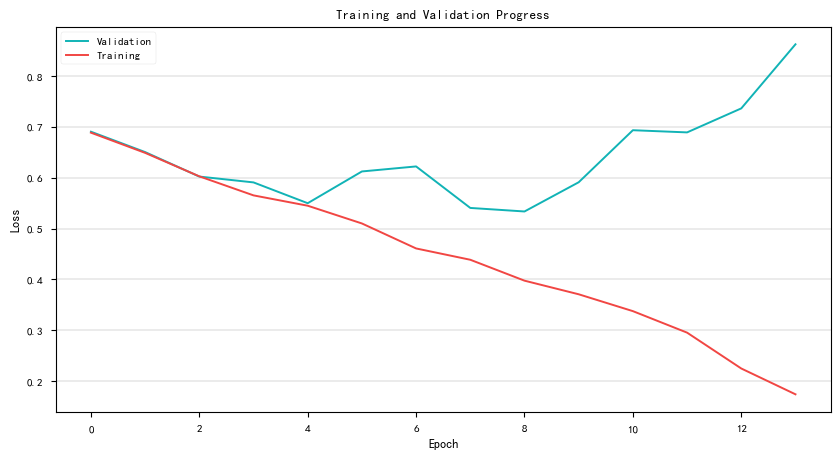

In [29]:
# 构造参数字典
params4 = {
    "train_args": {
        "model_name": CNN,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.CrossEntropyLoss(),
        "patience": 5,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/CNN_C",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'input_channels': 3,
        'num_classes': 2,
        'input_size': 224,
        'conv_layers': [
            (3, 32, 5),    # 第一层：输入3通道，输出32通道，卷积核大小为5x5
            (32, 64, 5),   # 第二层：输入32通道，输出64通道
            (64, 128, 5),   # 第三层：输入64通道，输出128通道
            (128, 256, 5),  # 第四层：输入128通道，输出256通道
        ],
        'fc_layers': [512, 256],
    },
}
model = train(**params4)

## 模型预测

In [64]:
def predict(predict_args, model_args):
    # 参数配置
    model_name = predict_args['model_name']
    data_path = predict_args['data_path']
    model_path = predict_args['model_path']
    device = predict_args['device']  # 可选'cuda'和'cpu'
    label_path = predict_args['label_path'] # 标签字典

    # 检查可用device
    device = torch.device(device)

    # 标签地址
    with open(os.path.join(label_path + '/idx_to_class.json'), 'r') as f:
        label_dicts = json.load(f)

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)

    # 构造数据集
    transform = transforms.Compose([
        transforms.Resize((224, 224)),         # 调整图像大小
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 颜色抖动
        transforms.ToTensor(),                  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])
    
    # 加载待预测数据
    labels = {}
    for file_name in os.listdir(data_path):
        # 检查文件是否为 .jpg 格式
        if file_name.endswith(".jpg"):
            file_path = os.path.join(data_path, file_name)  # 获取完整路径
            image = Image.open(file_path).convert('RGB')  # 确保是 RGB 图像
            X_true = transform(image).unsqueeze(0)  # 添加 batch 维度
            X_true = X_true.to(device)  # 移动到设备（CPU 或 GPU）
        
            # 模型预测
            model.eval()
            with torch.no_grad():
                X_true = X_true.to(device)
                outputs = model(X_true)
                # 计算准确率
                _, preds = torch.max(outputs, dim=1)
            labels[file_name] = label_dicts[str(preds.item())]
        else:
            pass

    return labels

In [65]:
# 构造参数字典
params6 = {
    "predict_args": {
        "model_name": CNN,
        "model_path": "../outputs/best_models/CNN_C/checkpoint.pth",
        "data_path": "../data/cats_and_dogs_small/test/cats",
        "device": 'cpu', 
        "label_path": "../outputs/labels"
    },
    "model_args": {
        'input_channels': 3,
        'num_classes': 2,
        'input_size': 224,
        'conv_layers': [
            (3, 32, 5),    # 第一层：输入3通道，输出32通道，卷积核大小为5x5
            (32, 64, 5),   # 第二层：输入32通道，输出64通道
            (64, 128, 5),   # 第三层：输入64通道，输出128通道
            (128, 256, 5),  # 第四层：输入128通道，输出256通道
        ],
        'fc_layers': [512, 256],
    },
}
y_pred = predict(**params6)

In [70]:
y_pred

{'cat.1500.jpg': 'cats',
 'cat.1501.jpg': 'cats',
 'cat.1502.jpg': 'cats',
 'cat.1503.jpg': 'cats',
 'cat.1504.jpg': 'cats',
 'cat.1505.jpg': 'cats',
 'cat.1506.jpg': 'cats',
 'cat.1507.jpg': 'dogs',
 'cat.1508.jpg': 'cats',
 'cat.1509.jpg': 'cats',
 'cat.1510.jpg': 'cats',
 'cat.1511.jpg': 'cats',
 'cat.1512.jpg': 'cats',
 'cat.1513.jpg': 'cats',
 'cat.1514.jpg': 'cats',
 'cat.1515.jpg': 'cats',
 'cat.1516.jpg': 'cats',
 'cat.1517.jpg': 'cats',
 'cat.1518.jpg': 'cats',
 'cat.1519.jpg': 'cats',
 'cat.1520.jpg': 'cats',
 'cat.1521.jpg': 'cats',
 'cat.1522.jpg': 'cats',
 'cat.1523.jpg': 'cats',
 'cat.1524.jpg': 'dogs',
 'cat.1525.jpg': 'cats',
 'cat.1526.jpg': 'cats',
 'cat.1527.jpg': 'cats',
 'cat.1528.jpg': 'cats',
 'cat.1529.jpg': 'cats',
 'cat.1530.jpg': 'cats',
 'cat.1531.jpg': 'dogs',
 'cat.1532.jpg': 'dogs',
 'cat.1533.jpg': 'cats',
 'cat.1534.jpg': 'cats',
 'cat.1535.jpg': 'cats',
 'cat.1536.jpg': 'cats',
 'cat.1537.jpg': 'cats',
 'cat.1538.jpg': 'cats',
 'cat.1539.jpg': 'cats',


In [68]:
# def predict(predict_args, model_args):
#     # 参数配置
#     model_name = predict_args['model_name']
#     data_path = predict_args['data_path']
#     model_path = predict_args['model_path']
#     device = predict_args['device']  # 可选'cuda'和'cpu'
#     label_path = predict_args['label_path'] # 标签字典

#     # 检查可用device
#     device = torch.device(device)

#     # 标签地址
#     with open(os.path.join(label_path + '/idx_to_class.json'), 'r') as f:
#         label_dicts = json.load(f)

#     # 加载模型
#     model = model_name(**model_args)
#     state_dict = torch.load(model_path, map_location=device)
#     model.load_state_dict(state_dict)
#     model = model.to(device)

#     # 构造数据集
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),         # 调整图像大小
#         transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
#         transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 颜色抖动
#         transforms.ToTensor(),                  # 转换为张量
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
#     ])
    
#     # 加载数据
#     image = Image.open(data_path).convert('RGB')  # 确保是 RGB 图像
#     X_true = transform(image).unsqueeze(0)  # 添加 batch 维度
#     X_true = X_true.to(device)  # 移动到设备（CPU 或 GPU）

#     # 模型预测
#     model.eval()
#     with torch.no_grad():
#         X_true = X_true.to(device)
#         outputs = model(X_true)
#         # 计算准确率
#         _, preds = torch.max(outputs, dim=1)

#     return label_dicts[str(preds.item())]

# 基于YOLO的图像分类算法

## 数据准备

要为 Ultralytics YOLO 分类任务构建数据集，遵循特定的拆分目录格式。将数据集组织到单独的目录中，用于训练、测试和可选的验证。每个目录都应包含以每个类命名的子目录，其中包含相应的图像。每个目录都应包含数据集中每个类的一个子目录。子目录以相应的类命名，并包含该类的所有图像。确保每个图像文件都有唯一的命名并以通用格式（例如 JPEG 或 PNG）存储。数据集格式：

## 模型训练

### 预训练模型

In [2]:
model = YOLO("yolo11n-cls.pt")
results = model.train(
    data="D:/Jupyter notebook/src/01.python/04.application/05.cv/data/cats_and_dogs_small_yolo", epochs=5, imgsz=224, batch=16, device='cuda')
metrics = model.val()

100%|█████████████████████████████████████████████████████████████████████████████| 5.52M/5.52M [00:04<00:00, 1.40MB/s]


Ultralytics 8.3.54  Python-3.9.18 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
engine\trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=D:/Jupyter notebook/src/01.python/04.application/05.cv/data/cats_and_dogs_small_yolo, epochs=5, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:05<00:00, 1.11MB/s]


AMP: checks passed 


train: Scanning D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\train... 2000 imag


train: New cache created: D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\train.cache


val: Scanning D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\val... 1000 images, 

val: New cache created: D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\classify\train
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:01<00:00, 21.14it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:01<00:00, 18.60it/s]

                   all      0.959          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:01<00:00, 25.09it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:01<00:00, 22.81it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:01<00:00, 21.76it/s]

                   all      0.978          1



5 epochs completed in 0.020 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.2MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.2MB

Validating runs\classify\train\weights\best.pt...
Ultralytics 8.3.54  Python-3.9.18 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
YOLO11n-cls summary (fused): 112 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\train... found 2000 images in 2 classes  
val: D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\val... found 1000 images in 2 classes  
test: D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\test... found 1000 images in 2 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:03<00:00,  9.41it/s]


                   all      0.978          1
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train
Ultralytics 8.3.54  Python-3.9.18 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
YOLO11n-cls summary (fused): 112 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\train... found 2000 images in 2 classes  
val: D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\val... found 1000 images in 2 classes  
test: D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\test... found 1000 images in 2 classes  


val: Scanning D:\Jupyter notebook\src\01.python\04.application\05.cv\data\cats_and_dogs_small_yolo\val... 1000 images, 
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:02<00:00, 25.01it/s]


                   all      0.978          1
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train2


In [3]:
top1 = metrics.top1  # top1 accuracy
top5 = metrics.top5  # top5 accuracy
print("top1 accuracy: ", top1)
print("top5 accuracy: ", top5)

top1 accuracy:  0.9779999852180481
top5 accuracy:  1.0


## 模型预测

### 预测单张图

In [4]:
# 加载最佳权重
trained_model = YOLO("../outputs/best_models/YOLO/runs/classify/train/weights/best.pt")

In [6]:
img = cv2.imread("../data/cats_and_dogs_small_yolo/train/cats/cat.2.jpg")
results = trained_model.predict(source=img, save=True, save_txt=True, device='cuda') 


0: 224x224 cats 1.00, dogs 0.00, 7.2ms
Speed: 16.3ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Results saved to runs\classify\predict
1 label saved to runs\classify\predict\labels


In [11]:
print(results)

[ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'cats', 1: 'dogs'}
obb: None
orig_img: array([[[ 53,  53,  65],
        [ 55,  55,  67],
        [ 36,  36,  48],
        ...,
        [123, 142, 147],
        [108, 126, 133],
        [ 85, 103, 110]],

       [[ 45,  42,  57],
        [ 51,  48,  63],
        [ 44,  41,  56],
        ...,
        [151, 170, 175],
        [118, 136, 143],
        [ 74,  92,  99]],

       [[ 80,  72,  89],
        [ 69,  61,  78],
        [ 45,  37,  54],
        ...,
        [142, 160, 167],
        [122, 139, 148],
        [ 84, 101, 110]],

       ...,

       [[150, 142, 149],
        [115, 107, 114],
        [ 66,  58,  68],
        ...,
        [ 65,  61,  72],
        [159, 158, 168],
        [199, 201, 211]],

       [[146, 139, 146],
        [114, 107, 114],
        [ 68,  60,  70],
        ...,
        [118, 116, 128],
        [185, 185, 197],
        [207, 211, 222]],

       [[14

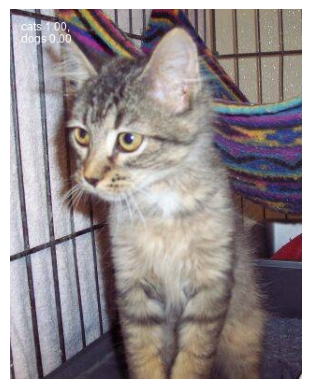

In [15]:
# 查看结果
image = Image.open("../outputs/best_models/YOLO/runs/classify/predict/image0.jpg")
# 显示图像
plt.imshow(image)
plt.axis("off")  # 隐藏坐标轴
plt.show()

### 预测多张图

In [19]:
img_path = "../data/cats_and_dogs_small/test/cats/"
results = trained_model.predict(source=img_path, save=True, save_txt=True, device='cuda') 


image 1/500 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\test\cats\cat.1500.jpg: 224x224 cats 1.00, dogs 0.00, 11.1ms
image 2/500 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\test\cats\cat.1501.jpg: 224x224 cats 1.00, dogs 0.00, 6.8ms
image 3/500 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\test\cats\cat.1502.jpg: 224x224 cats 1.00, dogs 0.00, 7.0ms
image 4/500 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\test\cats\cat.1503.jpg: 224x224 cats 1.00, dogs 0.00, 9.4ms
image 5/500 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\test\cats\cat.1504.jpg: 224x224 cats 1.00, dogs 0.00, 6.6ms
image 6/500 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\test\cats\cat.1505.jpg: 224x224 cats 1.00, dogs 0.00, 7.0ms
image 7/500 D:\Jupyter notebook\src\01.pytho

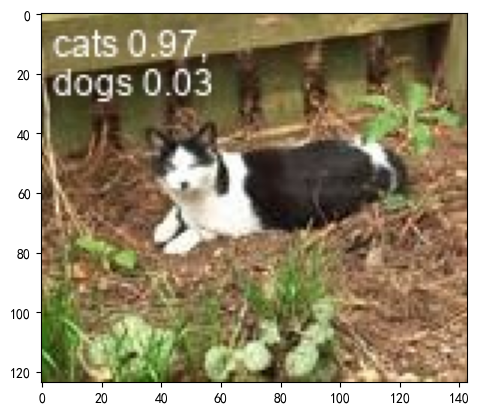

In [20]:
# 查看结果
image = Image.open("../outputs/best_models/YOLO/runs/classify/predict/cat.1507.jpg")
# 显示图像
plt.imshow(image)
# plt.axis("off")  # 隐藏坐标轴
plt.show()